In [47]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, BatchNormalization, Dense
from keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

#local module that I created to help with text preprocessing
import text_processing as t_proc

In [2]:
VIDHYA_DATA = 'training_data/vidhya_data.csv'
NAACL_DATA = 'training_data/NAACL_data.csv'

vidhya_data = pd.read_csv(VIDHYA_DATA, usecols=['label', 'tweet'])
naacl_data = pd.read_csv(NAACL_DATA, usecols=['label', 'tweet'])

training_data = pd.concat([vidhya_data, naacl_data]).reset_index(drop=True)

print(training_data.describe())
training_data.sample(10)

              label
count  43177.000000
mean       0.120226
std        0.325229
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


,label,tweet
15825,0,... such evil acts!
7656,0,ditching @user for prom really was #sad than...
28479,0,"ready for takeoff, kicking off my @user talkin..."
14352,0,couple having sex naked arabian
9897,0,a perfect day to take my fitness outside. wild...
1930,0,"here comes #monsoon2016 #mumbairains ,#delight..."
24839,0,@user the far left &amp; far right are lappin...
22264,1,@user the latest the blicqerâ¢ daily! thanks...
28718,0,@user @user should have come out strong agai...
15167,0,#fathersday to all our #heros !!! let us #ce...


In [3]:
tweets = list(training_data.tweet)
labels = np.array(training_data.label)

tweets_tokenized = [t_proc.tokenize_status_text(t) for t in tweets]

In [60]:
# Create hash for Twitter vocab

VOCAB_SIZE = 50000

counter = Counter()
for t in tweets_tokenized:
    counter.update(t)

vocab = [x[0] for x in counter.most_common(VOCAB_SIZE)]

# Reserve 0 for unknown tokens
hash_dict = dict((vocab[i], i+1) for i in range(VOCAB_SIZE))

# Save hashmap for later
with open('hashmap.json', 'w', encoding='utf-8') as fh:
    json.dump(hash_dict, fh)

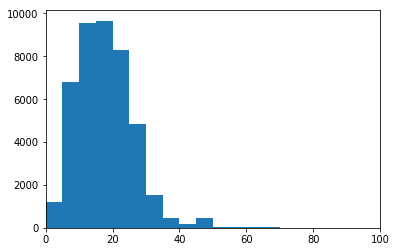

In [23]:
tweet_lens = [len(t) for t in tweets_tokenized]
plt.xlim((0,100))
plt.hist(tweet_lens, bins=range(0,100,5))
plt.show()

In [36]:
# Hash and pad tweets
MAX_INPUT_LEN = 30 # len 30 should be plenty based on previous histogram

def hash_token(t):
    hashcode = hash_dict.get(t)
    if hashcode is not None:
        return hashcode
    else:
        # Hash unknown tokens as 0
        return 0

tweets_hashed = [[hash_token(t) for t in tweet] for tweet in tweets_tokenized]
tweets_padded = pad_sequences(tweets_hashed, maxlen=MAX_INPUT_LEN)

In [30]:
# Create embedding dict from Glove pre-trained embeddings
EMBEDDING_DIM = 100
embedding_file = 'word_embeddings/glove.twitter.27B.{}d.txt'.format(EMBEDDING_DIM)

emb_dict = {}
with open(embedding_file, encoding='utf-8') as fh:
    for line in fh:
        chunks = line.split(' ')
        word = chunks[0]
        vec = np.array(chunks[1:], dtype='float32')
        emb_dict[word] = vec

In [37]:
# Create embedding matrix with hashmap and pre-trained embeddings

embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM), dtype='float32')
for i in range(1, VOCAB_SIZE+1):
    embedding_vector = emb_dict.get(vocab[i-1])
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    #If the embedding dict doesn't have this token, it will be translated
    # as a vector of zeroes.

# Build embedding layer to plug into Keras Sequential model
embedding = Embedding(input_dim=VOCAB_SIZE+1,
                      output_dim=EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_INPUT_LEN,
                      trainable=False)

In [61]:
# Construct model

model = Sequential()
model.add(embedding)
model.add(LSTM(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(amsgrad=True), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           5000100   
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 5,081,001
Trainable params: 80,701
Non-trainable params: 5,000,300
_________________________________________________________________


In [50]:
#The data is imbalanced, so we need to figure out what class weights to use
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(labels),
                                                  labels)

#Split into training and validation sets
np.random.seed(152)
X_train, X_test, y_train, y_test = train_test_split(tweets_padded, labels,
                                                    test_size=0.2, shuffle=True)

In [63]:
hist = model.fit(tweets_padded, labels,
                 batch_size=256, epochs=6,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights)

Train on 43177 samples, validate on 8636 samples
Epoch 1/6
43177/43177 [==============================] - 23s 522us/step - loss: 0.1481 - acc: 0.9421 - val_loss: 0.1351 - val_acc: 0.9473
Epoch 2/6
43177/43177 [==============================] - 24s 552us/step - loss: 0.1373 - acc: 0.9456 - val_loss: 0.1205 - val_acc: 0.9538
Epoch 3/6
43177/43177 [==============================] - 23s 530us/step - loss: 0.1254 - acc: 0.9511 - val_loss: 0.1083 - val_acc: 0.9616
Epoch 4/6
43177/43177 [==============================] - 24s 545us/step - loss: 0.1144 - acc: 0.9549 - val_loss: 0.0975 - val_acc: 0.9645
Epoch 5/6
43177/43177 [==============================] - 24s 547us/step - loss: 0.1059 - acc: 0.9588 - val_loss: 0.0888 - val_acc: 0.9676
Epoch 6/6
43177/43177 [==============================] - 24s 561us/step - loss: 0.0942 - acc: 0.9640 - val_loss: 0.0793 - val_acc: 0.9728


In [64]:
model.save('modelv2.h5')